In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.signal import resample
import matplotlib.pyplot as plt
import pandas as pd

from neuron_gill_c_interface import neuron_gill_sim

In [48]:
# ode model of SSD in neurons
def neuron_model(t, z):
    s_w, s_m, a_w, a_m = z
    
    # birth reactions
    b_s_w = 2*MU + C_B*(NSS_S-s_w-s_m*DELTA) 
    b_s_m = 2*MU + C_B*(NSS_S-s_w-s_m*DELTA)
    b_a_w = 0
    b_a_m = 0
    
    # death reactions
    d_s_w = MU
    d_a_w = MU
    d_s_m = MU
    d_a_m = MU
    
    # transport reactions
    t_s_a_w = 2*GAMMA + C_T*(NSS_A-a_w-a_m*DELTA)
    t_s_a_m = 2*GAMMA + C_T*(NSS_A-a_w-a_m*DELTA)
    t_a_s_w = GAMMA
    t_a_s_m = GAMMA
    
    
    return [s_w*(b_s_w-d_s_w-t_s_a_w) + a_w*t_a_s_w, 
            s_m*(b_s_m-d_s_m-t_s_a_m) + a_m*t_a_s_m, 
            a_w*(b_a_w-d_a_w-t_a_s_w) + s_w*t_s_a_w, 
            a_m*(b_a_m-d_a_m-t_a_s_m) + s_m*t_s_a_m,]

### Parameters of the simulation

In [66]:
## BIOLOGICAL PARAMETERS ##
MU = 0.07 # death rate
GAMMA = 0.05 # transport rate
DELTA = 0.5 # mutant deficiency
C_B = 0.1 # birth adaptibility constant
C_T = 0.00 # transport adaptibility constant
NSS_S = 200 # soma population size
NSS_A = 200 # axon population size

## VARIABLE NAMES ##
VARS = ['Ws', 'Ms', 'Wa', 'Ma']

## SIMULATION PARAMETERS ##
MAX_T = 500
TIME_POINTS = np.linspace(0, MAX_T, 500)
start_state = np.array([190, 20, 190, 20], dtype = np.int64)

## Deterministic simulation

In [67]:
sol = integrate.solve_ivp(neuron_model, [0, MAX_T], start_state, t_eval=TIME_POINTS, 
                          method = 'LSODA' # eq system is stiff, needs a solver that can handle such cases
                         )

results = sol.y

Final counts:
Ws	190.11	
Ms	20.01	
Wa	158.43	
Ma	16.68	
Final effective population size:
soma: 200.12
axon: 166.76


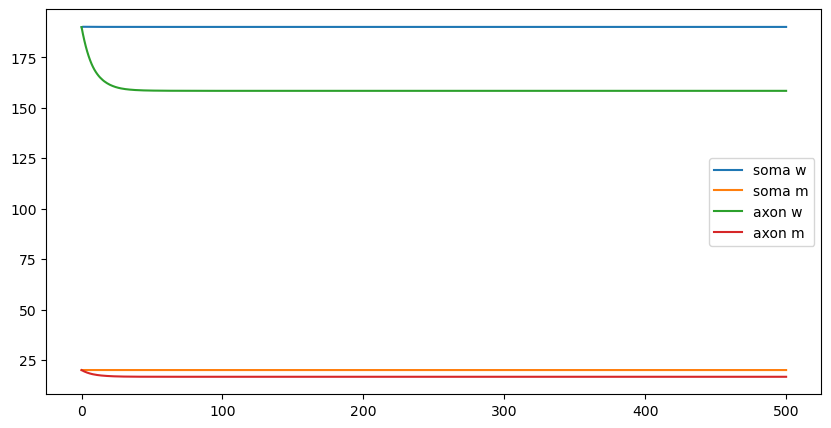

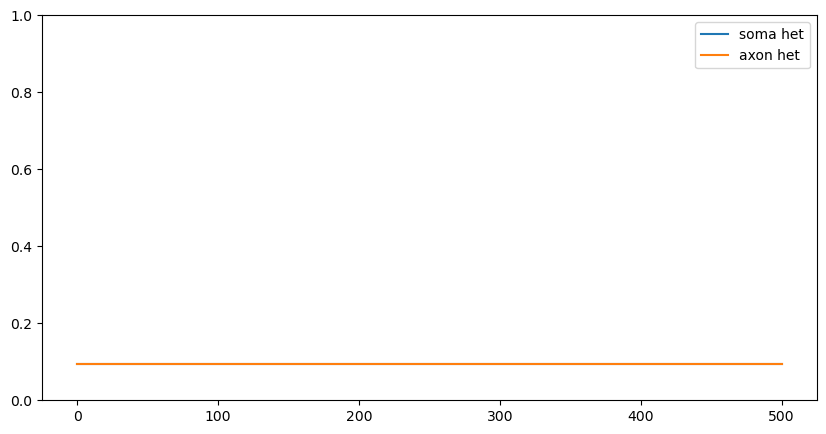

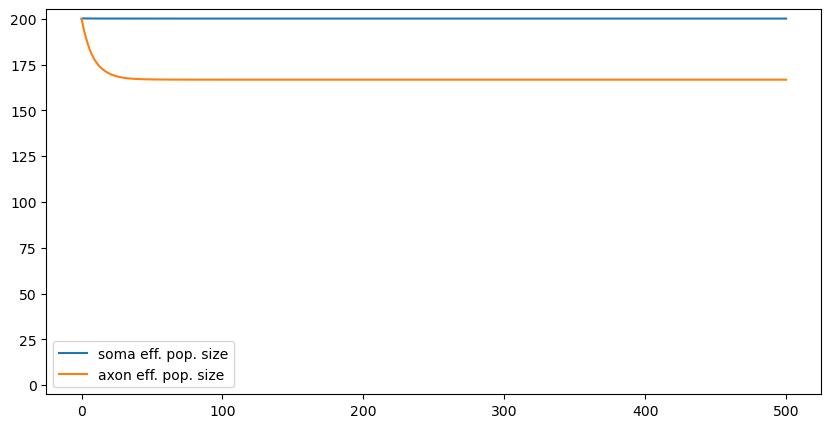

In [68]:
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, results[0], label = 'soma w')
plt.plot(TIME_POINTS, results[1], label = 'soma m')
plt.plot(TIME_POINTS, results[2], label = 'axon w')
plt.plot(TIME_POINTS, results[3], label = 'axon m')
plt.legend()

soma_het = results[1]/(results[1]+results[0])
axon_het = results[3]/(results[3]+results[2])
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, soma_het, label = 'soma het')
plt.plot(TIME_POINTS, axon_het, label = 'axon het')
plt.ylim([0, 1])
plt.legend()

soma_count = results[1]*DELTA+results[0]
axon_count = results[3]*DELTA+results[2]
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, soma_count, label = 'soma eff. pop. size')
plt.plot(TIME_POINTS, axon_count, label = 'axon eff. pop. size')
plt.ylim(min(0, min(soma_count), min(axon_count)) - 5, max(max(soma_count), max(axon_count)) + 5)
plt.legend()

print("Final counts:")
for i, res in enumerate(results[:,-1]): print(f'{VARS[i]}\t{round(res,2)}\t')

print("Final effective population size:")
print("soma:",round(soma_count[-1],2))
print("axon:",round(axon_count[-1],2))

## Pooled results from Gillespie based simulation

In [71]:
REPLICATES = 100000
replicate_results = np.zeros((REPLICATES, 4, TIME_POINTS.size), dtype = np.int64)

print('simulating...')
for i in range(REPLICATES):
    replicate_results[i, :, :] = np.swapaxes(neuron_gill_sim(MU, GAMMA, DELTA, C_B, C_T, NSS_S, NSS_A, TIME_POINTS, start_state), 0, 1)
    print(f"{round(((i+1)/REPLICATES)*100, 2)}% completed  ", end = "\r")
    
results = np.mean(replicate_results, axis = 0)

simulating...


Final counts:
Ws	187.39	
Ms	25.58	
Wa	156.27	
Ma	21.26	
Final effective population size:
soma: 200.18
axon: 166.9


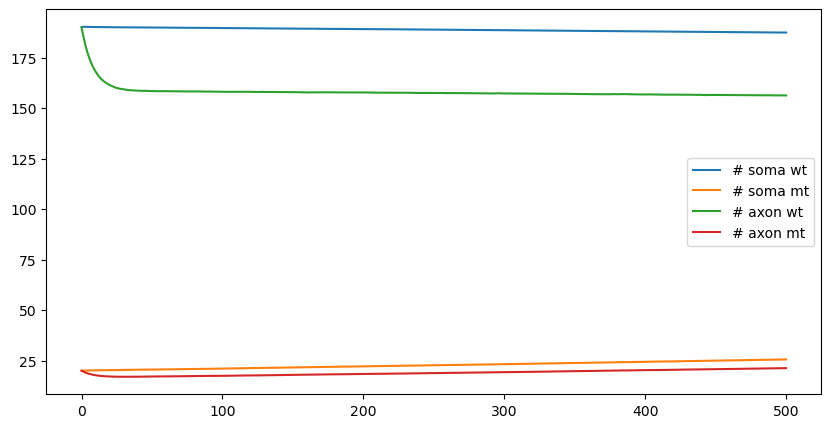

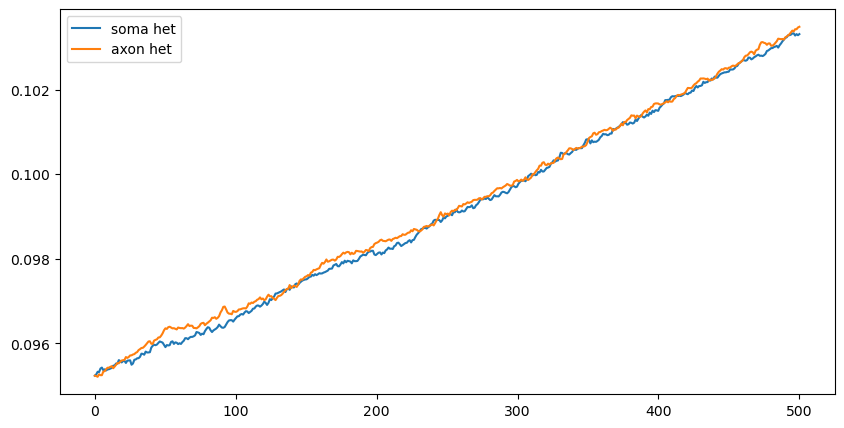

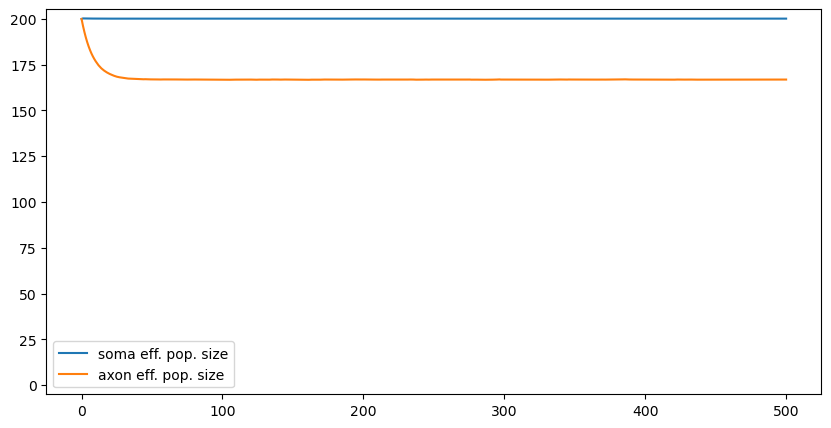

In [74]:
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, results[0], label = '# soma wt')
plt.plot(TIME_POINTS, results[1], label = '# soma mt')
plt.plot(TIME_POINTS, results[2], label = '# axon wt')
plt.plot(TIME_POINTS, results[3], label = '# axon mt')
plt.legend()

soma_het = np.mean(replicate_results[:,1,:]/(replicate_results[:,1,:]+replicate_results[:,0,:]), axis = 0)
axon_het = np.mean(replicate_results[:,3,:]/(replicate_results[:,3,:]+replicate_results[:,2,:]), axis = 0)
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, soma_het, label = 'soma het')
plt.plot(TIME_POINTS, axon_het, label = 'axon het')
plt.legend()

soma_count = np.mean(replicate_results[:,1,:]*DELTA+replicate_results[:,0,:], axis = 0)
axon_count = np.mean(replicate_results[:,3,:]*DELTA+replicate_results[:,2,:], axis = 0)
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, soma_count, label = 'soma eff. pop. size')
plt.plot(TIME_POINTS, axon_count, label = 'axon eff. pop. size')
plt.ylim(min(0, min(soma_count), min(axon_count)) - 5, max(max(soma_count), max(axon_count)) + 5)
plt.legend()

print("Final counts:")
for i, res in enumerate(results[:,-1]): print(f'{VARS[i]}\t{round(res,2)}\t')

print("Final effective population size:")
print("soma:",round(soma_count[-1],2))
print("axon:",round(axon_count[-1],2))